In [1]:
import sqlite3
import pandas as pd
from sklearn import datasets, metrics, linear_model, neural_network, model_selection, ensemble
import matplotlib
%matplotlib inline
matplotlib.rcParams.update(
    {'font.size': 22, 'figure.figsize': (16, 8)} # Make font and chart larger.
)

In [3]:
conn = sqlite3.connect('/data/accounts.db')
curr = conn.cursor()

reddit_users_df = pd.read_sql_query("""SELECT *
                            FROM users
                            WHERE gender in ('male', 'female')""", conn)
conn.close()
reddit_users_df.head() 

,username,gender,orientation,age,subreddits
0,SmootieFakk,male,unknown,0,"Overwatch,movies,aww,dndnext,reddit.com,politi..."
1,dizzykitty,male,unknown,0,"nsfw_gifs,Overwatch,movies,AskRedditAfterDark,..."
2,JoshSidekick,male,unknown,0,"WayOfTheBern,pics,AnimalsBeingJerks,GetMotivat..."
3,probywan1337,male,unknown,0,"pics,LearnJapanese,GolfStory,bestof,KratomKorn..."
4,GutenBourbon,male,unknown,0,"spicy,holdmyfries,IAmA,AskOuija,UpliftingNews,..."


In [5]:
len(reddit_users_df)

511

In [7]:
# How often each value appears
reddit_users_df['gender'].value_counts() 

male      372
female    139
Name: gender, dtype: int64

In [8]:
reddit_users_df[reddit_users_df['gender']=='male'].sample(10)

,username,gender,orientation,age,subreddits
495,Dro24,male,unknown,0,"hiphopheads,CollegeBasketball,n64,supremecloth..."
342,66o4dP73pb7,male,unknown,0,"exmormon,reloading,geology,ExMo_Christianity"
53,AirFell85,male,unknown,0,"delusionalcraigslist,absolver,modnews,wwiipics..."
263,OaklandCali,male,unknown,0,"CampfireCooking,korea,amihot,slowcooking,japan..."
382,TheTurtleTamer,male,unknown,0,"delusionalcraigslist,meirl,likeus,shittyfoodpo..."
472,aggsalad,male,unknown,0,"AskWomen,Whatcouldgowrong,summonerschool,video..."
179,s1ugg0,male,unknown,0,"niceguys,Whatcouldgowrong,dogpictures,OldSchoo..."
498,DrummingViking,male,unknown,0,"AskWomen,KotakuInAction,onewordeach,beermoney,..."
235,KonichiwaB1chez,male,unknown,0,"buildapc,southpark,adventuretime,survivorzero,..."
223,pegged50,male,unknown,0,"Shitty_Car_Mods,AskRedditNSFW,WTF,pegging_unki..."


There's more male than female here. We can beat 50% accuracy just by saying everyone is male

In [72]:
always_male_acc = metrics.accuracy_score(
    reddit_users_df['gender'],
    ['male']*len(reddit_users_df)
)


print('Accuracy if we call everything male: %.2f%%' % (always_male_acc*100))

Accuracy if we call everything male: 72.80%


In [73]:
male_users = reddit_users_df[reddit_users_df['gender']=='male']
female_users = reddit_users_df[reddit_users_df['gender']=='female']

male_users.head()

,username,gender,orientation,age,subreddits
0,SmootieFakk,male,unknown,0,"Overwatch,movies,aww,dndnext,reddit.com,politi..."
1,dizzykitty,male,unknown,0,"nsfw_gifs,Overwatch,movies,AskRedditAfterDark,..."
2,JoshSidekick,male,unknown,0,"WayOfTheBern,pics,AnimalsBeingJerks,GetMotivat..."
3,probywan1337,male,unknown,0,"pics,LearnJapanese,GolfStory,bestof,KratomKorn..."
4,GutenBourbon,male,unknown,0,"spicy,holdmyfries,IAmA,AskOuija,UpliftingNews,..."


In [74]:
male_subs = pd.Series(pd.Series(
    male_users['subreddits'].values).str.cat(sep=',').lower().split(',')
                     )
                     

female_subs = pd.Series(pd.Series(
    female_users['subreddits'].values).str.cat(sep=',').lower().split(',')
                       )

male_subs.sample(10)

10515                 fallout
5780                 survivor
9717             streetfights
13803                   steam
11017                politics
5533                 notmyjob
15887                  europe
11792                     wtf
358                 worldnews
12934    damnthatsinteresting
dtype: object

In [75]:
# This code counts word frequencies, and then normalizes by total number of words.
# The result is the "rate" at which each subreddit appears.
male_subs_rates = male_subs.value_counts() / len(male_subs)
female_subs_rates = female_subs.value_counts() / len(female_subs)

male_subs_rates.sort_values(ascending=False).head(5)

askreddit        0.013701
pics             0.010425
funny            0.010226
todayilearned    0.009631
worldnews        0.009085
dtype: float64

In [76]:
female_subs_rates.sort_values(ascending=False).head()

askreddit        0.017199
funny            0.010206
pics             0.010017
todayilearned    0.009450
news             0.008505
dtype: float64

In [77]:
# We can divide spam word rates by ham word rates to find words that occur more in spam subject lines.
male_enriched_subs = (male_subs_rates / female_subs_rates).sort_values(ascending=False)
male_enriched_subs.head(5)

guns                    6.303813
firstworldanarchists    5.253177
bad_cop_no_donut        5.253177
baseball                5.253177
askouija                4.990518
dtype: float64

In [78]:
# These words are ranked by how much more often they show up in ham subject lines.
female_enriched_subs = (female_subs_rates / male_subs_rates).sort_values(ascending=False)
female_enriched_subs.head(5)

makeupaddiction    22.843319
wedding            15.228879
transpassing       15.228879
actuallesbians     15.228879
polyamory          15.228879
dtype: float64

### Features

In [80]:
reddit_users_df.head()

,username,gender,orientation,age,subreddits
0,SmootieFakk,male,unknown,0,"Overwatch,movies,aww,dndnext,reddit.com,politi..."
1,dizzykitty,male,unknown,0,"nsfw_gifs,Overwatch,movies,AskRedditAfterDark,..."
2,JoshSidekick,male,unknown,0,"WayOfTheBern,pics,AnimalsBeingJerks,GetMotivat..."
3,probywan1337,male,unknown,0,"pics,LearnJapanese,GolfStory,bestof,KratomKorn..."
4,GutenBourbon,male,unknown,0,"spicy,holdmyfries,IAmA,AskOuija,UpliftingNews,..."


In [86]:
# Let's get top subreddits.

male_enrichment = 5
female_enrichment = 10
top_male_subreddits = male_enriched_subs[male_enriched_subs > male_enrichment].index.tolist()
top_female_subreddits = female_enriched_subs[female_enriched_subs > female_enrichment].index.tolist()

# For each of these subreddits, we will create a "feature" column.
# If the word is in the subject line, we put a 1, otherwise, 0.
for word in top_male_subreddits + top_female_subreddits:
    reddit_users_df['feature_%s' % word] = reddit_users_df['subreddits'].str.lower().map(
        lambda subject: word in subject
    ).astype(int)

In [87]:
reddit_users_df.head()

,username,gender,orientation,age,subreddits,feature_guns,feature_firstworldanarchists,feature_bad_cop_no_donut,feature_baseball,feature_makeupaddiction,...,feature_polyamory,feature_bpd,feature_india,feature_firstimpression,feature_gendercritical,feature_transtimelines,feature_askvet,feature_college,feature_sandiego,feature_saplings
0,SmootieFakk,male,unknown,0,"Overwatch,movies,aww,dndnext,reddit.com,politi...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,dizzykitty,male,unknown,0,"nsfw_gifs,Overwatch,movies,AskRedditAfterDark,...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,JoshSidekick,male,unknown,0,"WayOfTheBern,pics,AnimalsBeingJerks,GetMotivat...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,probywan1337,male,unknown,0,"pics,LearnJapanese,GolfStory,bestof,KratomKorn...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,GutenBourbon,male,unknown,0,"spicy,holdmyfries,IAmA,AskOuija,UpliftingNews,...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
len(reddit_users_df.columns)-2

21

It's generally a good idea to explore the distribution of your features.

In [92]:

reddit_users_df['feature_guns'].value_counts()

0    478
1     33
Name: feature_guns, dtype: int64

In [93]:

pd.crosstab(reddit_users_df['feature_guns'], reddit_users_df['gender'])

gender,female,male
feature_guns,,
0,137,341
1,2,31


### Random forest model version 1

In [100]:
# Our model will need to know which columns contain features.
features = [col for col in reddit_users_df if col.startswith('feature')]
features

['feature_guns',
 'feature_firstworldanarchists',
 'feature_bad_cop_no_donut',
 'feature_baseball',
 'feature_makeupaddiction',
 'feature_wedding',
 'feature_transpassing',
 'feature_actuallesbians',
 'feature_polyamory',
 'feature_bpd',
 'feature_india',
 'feature_firstimpression',
 'feature_gendercritical',
 'feature_transtimelines',
 'feature_askvet',
 'feature_college',
 'feature_sandiego',
 'feature_saplings']

In [101]:
len(features)

18

In [102]:
features.append('gender')

In [128]:
data = reddit_users_df[features]
data = data.replace({'male':1, 'female':0})
data.head()

,feature_guns,feature_firstworldanarchists,feature_bad_cop_no_donut,feature_baseball,feature_makeupaddiction,feature_wedding,feature_transpassing,feature_actuallesbians,feature_polyamory,feature_bpd,feature_india,feature_firstimpression,feature_gendercritical,feature_transtimelines,feature_askvet,feature_college,feature_sandiego,feature_saplings,gender
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [129]:
import pandas as pd
import numpy as np
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


def save_model(model, path='model.pkl'):
    """
    Saves the best model found by the GridSearch for use on the website
    ------------
    Input
    -----------
    path: String indicating pickle location
    ------------
    Returns
    ------------
    None
    """
    with open(path, 'wb') as f:
        pickle.dump(model, f)

def run_gridsearch(df, models, target='is_fraud', path='model.pkl', \
                    scoring='recall', verbose=True, show_figs=False, \
                    test_size=0.2, cv=5):
    """
    Runs a grid search and saves the best model for use on the website
    ------------
    Input
    ------------
    # Could change language to reflect other data types that should still work?

    df: Pandas Dataframe with column labeled input param target
    models: List of Tuples of (model, parameters)
    target: String indicating which column is the target variable
    path: String of path for pickle file to save model (default='model.pkl')
    scoring: String scoring metric to use (default='recall')
    verbose: Bool Prints scores during fit (default=True)

    ------------
    Returns
    ------------
    None
    """


    # SKlearn models take numbers to indicate verbosity
    # We want to be able to output nothing (verbose=False), the outputs defined
    # in this function (verbose=True) or the indicated verbosity level
    # (verbose = int).
    # Verbosity sets the verbosity of the grid search. Verbosity of indivicual
    # models is set below because some models do not have the parameter

    if verbose > 1:
        verbosity = verbose
    elif verbose is 1:
        verbosity = 1
    else:
        verbosity = 0

    # Set up flexible fbeta scoring
    if 'f' in scoring or 'F' in scoring and scoring != 'f1':
        beta = float(scoring.replace('f',''))
        scorer = metrics.make_scorer(metrics.fbeta_score, beta=beta)
    else:
        scorer = scoring


    # Store the best model
    best_models = []

    # Split the target variable from the data
    y = df.pop(target)

    # Perform train test split
    # GridSearchCV performs 3-fold cross validation. Verify best model with test
    # data
    X_train, X_test, y_train, y_test = train_test_split(df, y, \
                                                        test_size=test_size)

    # Provide weights to the models if classes are imblanaced
    # Get the ratio of the positive class to the negative class
    # immediately convert to a weight (1/ratio)
    # weight = len(y_train)/float(sum(y_train))

    # Generate array wtih ratio of 1/ratio (i.e., weight):1 to balance classes
    # sw_train = [weight * y if y == 1 else 1 for y in y_train]
    
    sw_train = y_train

    # Grid search the models
    for classifier, parameters in models:
        # Not to be confused with best estimator name, which is used at the end
        clf_name = classifier.__class__.__name__
        # Set some verbosity options differentiating between 1 and True
        # where True only outputs Grid Search and this function's outputs
        # and >= 1 will output the verbosity levels from the models
        if 'verbose' in dir(classifier):
            if verbose is 1:  # True == 1 -> True; True is 1 -> False
                parameters['verbose'] = [1]
            elif verbose > 1:
                parameters['verbose'] = [verbose]

        print('==============================')
        print('Fitting {}...'.format(clf_name))
        clf = GridSearchCV(classifier, parameters, scoring=scorer, \
                                verbose=verbosity, cv=cv)
        clf.fit(X_train, y_train, sample_weight=sw_train)

        # Make predictions and get scores
        y_pred = clf.predict(X_test)
        y_probs = clf.predict_proba(X_test)
        precision_score = metrics.precision_score(y_test, y_pred)
        recall_score = metrics.recall_score(y_test, y_pred)
        f1_score = metrics.f1_score(y_test, y_pred)
        auc_score = metrics.roc_auc_score(y_test, y_probs[:,1])
        accuracy_score = metrics.accuracy_score(y_test, y_pred)
        if 'f' in scoring and scoring != 'f1':
            fb_score = metrics.fbeta_score(y_test, y_pred, beta)


        # Print out scores
        if verbose:
            print('==============================')
            print('Best Parameters for {}'.format(clf_name))
            for k,v in clf.best_params_.items():
                print('{}: {}'.format(k,v))
            if 'feature_importances_' in dir(clf.best_estimator_):
                print('==============================')
                print('Features ordered by importance:')
                top_features = np.argsort(clf.best_estimator_.feature_importances_)
                for i, feat in enumerate(df.columns[top_features][::-1]):
                    print('{}. {}'.format(i+1, feat))
                # Verify the correct order
                #print(clf.best_estimator_.feature_importances_[top_features][::-1])

            print('==============================')
            print('Confusion Matrix:')
            print(metrics.confusion_matrix(y_test, y_pred))
            print('Recall Score:\t\t{:.3f}'.format(recall_score))
            print('Accuracy Score:\t\t{:.3f}'.format(accuracy_score))
            print('Precision Score:\t{:.3f}'.format(precision_score))
            print('F1 Score:\t\t{:.3f}'.format(f1_score))
            print('ROC AUC Score:\t\t{:.3f}'.format(auc_score))
            if 'f' in scoring and scoring != 'f1':
                print('F{:.1f} Score:\t\t{:.3f}'.format(beta, fb_score))
            print('==============================')

        if show_figs:

            precision, recall, _ = metrics.precision_recall_curve(y_test, \
                                                                y_probs[:,1])
            plt.plot(recall, precision)
            plt.title('Precision-Recall curve For {}'.format(clf_name))
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.show()

            fpr, tpr, _ = metrics.roc_curve(y_test, y_probs[:,1])
            plt.plot(fpr, tpr)
            plt.title('ROC Curve for {}'.format(clf_name))
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.show()

        # Pick store the model using the indicated metric
        if scoring=='recall':
            best_models.append((recall_score, clf))
        elif scoring=='precision':
            best_models.append((precision_score, clf))
        elif scoring=='f1':
            best_models.append((f1_score, clf))
        elif scoring=='roc_auc':
            best_models.append((auc_score, clf))
        elif scoring=='accuracy':
            best_models.append((accuracy_score, clf))
        else: # FBeta
            best_models.append((fb_score, clf))

    # Save the best model
    best_models.sort() # sort by the score indicated above
    # different from clf_name, which is the name of the current edmodel
    best_model_name = best_models[-1][1].best_estimator_.__class__.__name__
    print('Best model: {}'.format(best_model_name))
    print('Best {} score: {:.3f}'.format(scoring, best_models[-1][0]))
    save_model(best_models[-1][1], path)


Running gridsearch...
Fitting RandomForestClassifier...
Best Parameters for RandomForestClassifier
max_depth: 5
max_features: auto
max_leaf_nodes: None
min_impurity_decrease: 0
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 200
n_jobs: 3
oob_score: False
Features ordered by importance:
1. feature_saplings
2. feature_sandiego
3. feature_firstworldanarchists
4. feature_bad_cop_no_donut
5. feature_baseball
6. feature_makeupaddiction
7. feature_wedding
8. feature_transpassing
9. feature_actuallesbians
10. feature_polyamory
11. feature_bpd
12. feature_india
13. feature_firstimpression
14. feature_gendercritical
15. feature_transtimelines
16. feature_askvet
17. feature_college
18. feature_guns
Confusion Matrix:
[[ 0 24]
 [ 0 79]]
Recall Score:		1.000
Accuracy Score:		0.767
Precision Score:	0.767
F1 Score:		0.868
ROC AUC Score:		0.500
F2.0 Score:		0.943


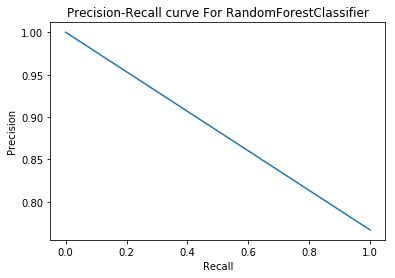

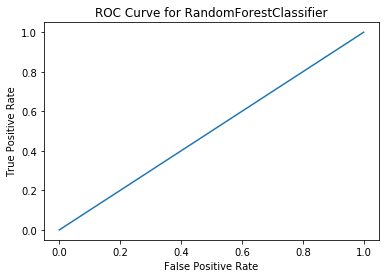

Best model: RandomForestClassifier
Best f2 score: 0.943


In [130]:
# gb = GradientBoostingClassifier()
# gb_params = {
#                 'learning_rate': [0.1],
#                 'n_estimators': [200],
#                 'max_depth' : [5],
#                 'min_samples_split': [2],
#                 'min_samples_leaf': [1],
#                 'min_weight_fraction_leaf': [0.],
#                 'subsample': [0.9],
#                 'max_features' : ['auto'],
#                 'max_leaf_nodes': [None],
#                 'min_impurity_decrease': [0.]
#              }
# gb_options = (gb, gb_params)

ada = AdaBoostClassifier()
ada_params = {
                'base_estimator':[RandomForestClassifier()], # DecisionTreeClassifier(),
                'n_estimators': [200],
                'learning_rate': [1.]
             }
ada_options = (ada, ada_params)

rf = RandomForestClassifier()
rf_params = {
                'n_estimators':[200],
                'max_features': ['auto', None],
                'max_depth': [5],
                'min_samples_split': [2], # min 2
                'min_samples_leaf': [1],
                'max_leaf_nodes' : [None],
                'min_impurity_decrease': [0],
                'oob_score': [False],
                'n_jobs': [3], # left myslef 1 core
            }
rf_options = (rf, rf_params)

# Performs terribly probably because it doesn't take sample weights
# Some other oversampling technqiue could be useful
# nn = MLPClassifier()
# nn_params = {
#                 'hidden_layer_sizes': [(100), (100,100), (100,100,100)],
#                 'activation': ['tanh', 'relu'],
#                 'early_stopping': [False],
#                 'max_iter' : [200,2000,10000]
#             }
# nn_options = (nn, nn_params)

# print('Loading clean data from pickle...')
# data = pd.read_pickle('data/cleaned_data.pkl')
print('Running gridsearch...')
run_gridsearch(data, [rf_options], scoring='f2', show_figs=True, target='gender')

In [59]:
# Create a new classifier
rf_clf_v1 = ensemble.RandomForestClassifier( # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    n_estimators=32, # How many trees? More is better, but slower.
    n_jobs=-1
)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
# Make predictions
rf_v1_predictions_train = rf_clf_v1.predict(rga_TRAIN_df[features])
rf_v1_predictions_test = rf_clf_v1.predict(rga_TEST_df[features])

# Measure accuracy
rf_v1_acc_train = metrics.accuracy_score(rga_TRAIN_df['label'], rf_v1_predictions_train)
rf_v1_acc_test = metrics.accuracy_score(rga_TEST_df['label'], rf_v1_predictions_test)

print('Random Forest v1 TRAIN accuracy is: %.2f%%' % (rf_v1_acc_train*100))
print('Random Forest v1 TEST accuracy is: %.2f%%' % (rf_v1_acc_test*100))

Random Forest v1 TRAIN accuracy is: 91.55%
Random Forest v1 TEST accuracy is: 87.47%


Note the significant gap between train and test accuracy. The Random Forest algorithm can fit very tightly to data, sometimes too tightly. This is called "overfitting." We can see from the train/test accuracy gap that our model is fitting to aspects of the data that matter only for the training set, and don't generalize well.  

This is why we test! What can we do about it? More data is the best solution. As the amount of data you have increases, the gap between train and test accuracy generally *decreases*.

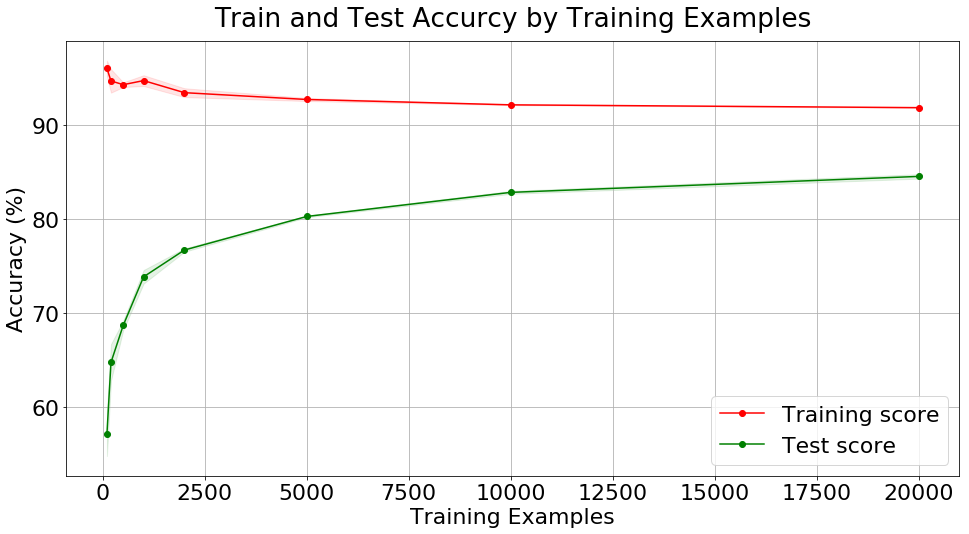

In [ ]:
# This code trains models using a range of training set sizes and plots the train and test accuracy.

# Here's the model we're going to evaluate
rf_clf_v1_lc = ensemble.RandomForestClassifier( # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    n_estimators=8, # How many trees? More is better, but slower.
    n_jobs=-1
)

# This function trains multiple models, 3 for each train size, and returns train and test score.
train_sizes, train_scores, test_scores = model_selection.learning_curve(
    rf_clf_v1_lc,
    rga_TRAIN_df[features],
    rga_TRAIN_df['label'],
    cv=3,
    train_sizes=[100, 200, 500, 1000, 2000, 5000, 10000, 20000]
)

# We average together scores from the 3 runs at each size
train_scores_mean = 100*train_scores.mean(axis=1)
train_scores_std = 100*train_scores.std(axis=1)
test_scores_mean = 100*test_scores.mean(axis=1)
test_scores_std = 100*test_scores.std(axis=1)

# Finally, let's plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.title('Train and Test Accurcy by Training Examples', y=1.02)
matplotlib.pyplot.xlabel('Training Examples')
matplotlib.pyplot.ylabel('Accuracy (%)')
matplotlib.pyplot.grid()
matplotlib.pyplot.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
matplotlib.pyplot.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
matplotlib.pyplot.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
matplotlib.pyplot.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score")
_ = matplotlib.pyplot.legend(loc="best")

### Model version 2: learn from version 1

What does model v1 miss?

In [62]:
rga_TRAIN_df[rga_TRAIN_df['label']!=rf_v1_predictions_train][['subject', 'label']].sample(30)

,subject,label
90264,Notice,spam
11545,RE: eNYMEX,ham
59592,RE: priorities for 1/16 and accomplishments fo...,ham
38917,RE: 2 things,ham
55301,RE: Big Pig,ham
36544,Dynegy Discussions,ham
74289,St0ck Maven Newsletter,spam
80926,To comb as smacker,spam
35148,快樂的最佳去趾watson@enron.com,spam
61719,Second Cataract Surgery,ham


In [63]:
def add_features_v2(df):
    df['feature_ALL_CAPS'] = (df['subject'] == df['subject'].str.upper()).astype(int)
    df['feature_all_lower'] = (df['subject'] == df['subject'].str.lower()).astype(int)
    df['feature_all_ascii_chars'] = df['subject'].map(lambda s: all(ord(c) < 128 for c in s)).astype(int)
    df['feature_$'] = df['subject'].map(lambda x: '$' in x).astype(int)
    df['feature_@'] = df['subject'].map(lambda x: '@' in x).astype(int)
    df['feature_0'] = df['subject'].map(lambda x: '0' in x).astype(int)
    df['feature_:)'] = df['subject'].map(lambda x: ':)' in x).astype(int)
    df['feature_memy'] = df['subject'].str.lower().map(lambda x: 'me' in x or 'my' in x).astype(int)
    df['feature_re'] = df['subject'].str.lower().map(lambda s: s.startswith('re:')).astype(int)
    df['feature_fwd'] = df['subject'].str.lower().map(lambda s: s.startswith('fw:') or s.startswith('fwd:')).astype(int)

add_features_v2(rga_TRAIN_df)
add_features_v2(rga_TEST_df)

In [64]:
pd.crosstab(rga_TRAIN_df['feature_all_ascii_chars'], rga_TRAIN_df['label'])

label,ham,spam
feature_all_ascii_chars,,
0,12,11019
1,29791,29970


In [65]:
pd.crosstab(rga_TRAIN_df['feature_fwd'], rga_TRAIN_df['label'])

label,ham,spam
feature_fwd,,
0,25654,40659
1,4149,330


In [66]:
# Our features have changed, so let's get the new set of names
features = [col for col in rga_TRAIN_df if col.startswith('feature')]

# Create a new classifier
rf_clf_v2 = ensemble.RandomForestClassifier( # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    n_estimators=32, # How many trees? More is better, but slower.
    n_jobs=-1
)

# Fit our training data
rf_clf_v2.fit(rga_TRAIN_df[features], rga_TRAIN_df['label'])

# Make predictions on train and test
rf_v2_predictions_train = rf_clf_v2.predict(rga_TRAIN_df[features])
rf_v2_predictions_test = rf_clf_v2.predict(rga_TEST_df[features])

# Evaluate performance
rf_v2_acc_train = metrics.accuracy_score(rga_TRAIN_df['label'], rf_v2_predictions_train)
rf_v2_acc_test = metrics.accuracy_score(rga_TEST_df['label'], rf_v2_predictions_test)

# Print results
print('Random Forest v2 TRAIN accuracy is: %.2f%%' % (rf_v2_acc_train*100))
print('Random Forest v2 TEST accuracy is: %.2f%%' % (rf_v2_acc_test*100))

Random Forest v2 TRAIN accuracy is: 95.96%
Random Forest v2 TEST accuracy is: 92.10%


### Model v3: ml can utilize very basic features

In [67]:
def add_features_v3(df):
    """A bunch of features that aren't particularly human-friendly."""
    df['feature_len'] = df['subject'].map(len)
    df['feature_words'] = df['subject'].map(lambda x: len(x.split()))
    df['feature_chars_per_word'] = (df['feature_len'] / df['feature_words']).fillna(0.)
    df['feature_digits'] = df['subject'].map(lambda x: sum(c.isdigit() for c in x))
    df['feature_punc'] = df['subject'].map(lambda s: sum([1 for x in s if x in set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')]))
    
add_features_v3(rga_TRAIN_df)
add_features_v3(rga_TEST_df)

In [68]:
# Our features have changed, so let's get the new set of names
features = [col for col in rga_TRAIN_df if col.startswith('feature')]

# Create a new classifier
rf_clf_v3 = ensemble.RandomForestClassifier( # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    n_estimators=32, # How many trees? More is better, but slower.
    n_jobs=-1
)

# Fit our training data
rf_clf_v3.fit(rga_TRAIN_df[features], rga_TRAIN_df['label'])

# Make predictions on train and test
rf_v3_predictions_train = rf_clf_v3.predict(rga_TRAIN_df[features])
rf_v3_predictions_test = rf_clf_v3.predict(rga_TEST_df[features])

# Evaluate performance
rf_v3_acc_train = metrics.accuracy_score(rga_TRAIN_df['label'], rf_v3_predictions_train)
rf_v3_acc_test = metrics.accuracy_score(rga_TEST_df['label'], rf_v3_predictions_test)

# Print results
print('Random Forest v3 TRAIN accuracy is: %.2f%%' % (rf_v3_acc_train*100))
print('Random Forest v3 TEST accuracy is: %.2f%%' % (rf_v3_acc_test*100))

Random Forest v3 TRAIN accuracy is: 99.47%
Random Forest v3 TEST accuracy is: 94.31%


In [ ]:
rga_TEST_df[rga_TEST_df['label']!=rf_v3_predictions_test][['subject', 'label']].sample(30)

Let's see how we did today:

In [69]:
results_summary_df = pd.DataFrame({
    'Model': ['Always Spam', 'Simple v1', 'Simple v2', 'RF v1', 'RF v2', 'RF v3'],
    'Train Accuracy': [100*always_spam_acc_train, 100*simple_acc_train, 100*simple_v2_acc_train, 100*rf_v1_acc_train, 100*rf_v2_acc_train, 100*rf_v3_acc_train],
    'Test Accuracy': [100*always_spam_acc_test, 100*simple_acc_test, 100*simple_v2_acc_test, 100*rf_v1_acc_test, 100*rf_v2_acc_test, 100*rf_v3_acc_test]
})
results_summary_df

,Model,Test Accuracy,Train Accuracy
0,Always Spam,58.398780,57.900610
1,Simple v1,60.477993,61.071873
2,Simple v2,81.863382,82.126511
3,RF v1,87.473869,91.554130
4,RF v2,92.095599,95.958583
5,RF v3,94.310413,99.473104


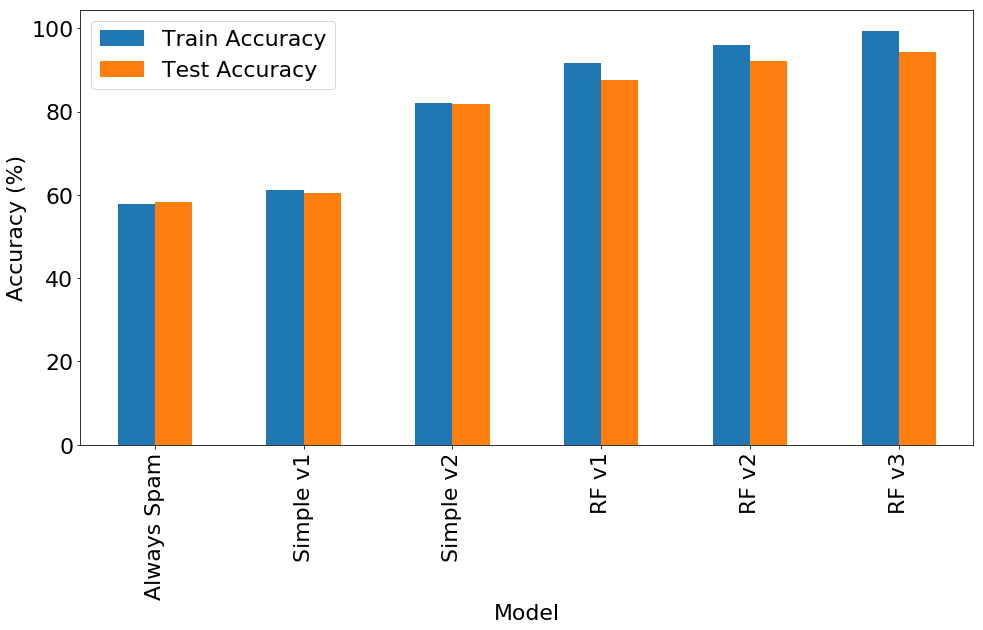

In [70]:
ax = results_summary_df.plot.bar('Model', ['Train Accuracy', 'Test Accuracy'])

_ = ax.set_ylabel('Accuracy (%)')

We started with a model that's barely better than guessing, and ended by building a machine learning model with greater than 90% accuracy. That's not the end, though; it is possible to acheive even better performance with this data, and I encourage everyone to start experimenting with new and better features as a way to learn.

# Learn More
I hope this intro has whetted your appetite. There are _tons_ of free resources online to learn more about these topics. Here are some of my favoriate.

* As mentioned previously, [Learn Python the Hard Way](https://learnpythonthehardway.org/book/) is a great resource for learning Python.
* [A visual introduction to machine learning](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/) is a fun way to build a little more intuition around basic ML concepts.
* Check out these [tutorials](http://pandas.pydata.org/pandas-docs/stable/tutorials.html) to learn more about notebooks and pandas.
* Once you have some familiarity with the basics of Python and ML, [scikit-learn's tutorials](http://scikit-learn.org/stable/tutorial/index.html) are good for building hands-on ML knowledge.
* In this training, we've pretty much exclusively used "error" and "accuracy" to evaluate machine learning models. That's not always the best thing to do. Read [Why accuracy alone is a bad measure for classification tasks, and what we can do about it](https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/) to learn why.
* Building intuition around bias and variance is an important fundamental skill. Start with Scott Fortmann-Roe's essay [Understanding the Bias-Variance Tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html).
* I also highly recommend reading this paper, [A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf), when you are ready to start using ML on your own.
* Finally, if you prefer a more formal classroom setting, [Andrew Ng's Coursera course on machine learning](https://www.coursera.org/learn/machine-learning) is a fantastic place to start. It's free!

# Extra Credit

In [ ]:
# Let's get more detailed information about the performance of our best model.
# Would you use it in production? Probably not.
print(metrics.classification_report(
    rga_TEST_df['label'], 
    rf_v3_predictions_test,
    digits=4
))

In [ ]:
# What if we could make sure the classifier only said 'spam' if it was particularly sure?
# We can do that by adjusting the probability threshold.

def probs_to_class(probs, threshold=0.5):
    # Converts raw spam probability to a label
    if probs > threshold:
        return 'spam'
    else:
        return 'ham'

pd.Series(rf_clf_v3.predict_proba(rga_TEST_df.head()[features])[:, 1]).map(probs_to_class)

In [ ]:
# By default, the classifier's threshold is 0.5.
# That means if the estimated spam probability is greater than 50%, label as spam.
print(metrics.classification_report(
    rga_TEST_df['label'],
    pd.Series(rf_clf_v3.predict_proba(rga_TEST_df[features])[:, 1]).map(
        lambda p: probs_to_class(p, 0.5)
    ),
    digits=4
))

In [ ]:
# Let's look at the distribution of probabilities in our test set.

ax = pd.Series(rf_clf_v3.predict_proba(rga_TEST_df[features])[:, 1]).plot.hist(bins=50, edgecolor='white')

In [ ]:
# Choosing a higher threshold gets you precision, but at the cost of recall.
print(metrics.classification_report(
    rga_TEST_df['label'],
    pd.Series(rf_clf_v3.predict_proba(rga_TEST_df[features])[:, 1]).map(
        lambda p: probs_to_class(p, 0.97)
    ),
    digits=3
))

## A note on running a model like this in production

With an adjusted threshold, this model is close to being suitable for real-world abuse detection as part of a broader portfolio of abuse detection techniques. However, there are a few things I would do before considering using this model in production:

1. Most importantly, the training set needs to be augmented with data from the actual mailstream you will be filtering. Every mailstream is different, and a ML model trained on one source of mail will perform worse, if not poorly, on a different one. The best thing you can do for your model is to gather and label your own training data, rather than relying on what is available from other sources. As a general rule of thumb (which you should test for yourself!), you should try to ensure that non-native data makes up no more than one-third of your training set. That means you need to collect a lot more samples. It takes less time than you would think; most people underestimate the value of simply spending time manually labeling more training samples.

2. Many of the features are based on particular words. We know that spammers try to avoid filtering by using variations on key words and phrases. Building features that are a little more flexible (for example, a feature that will catch "viagra" and anything within one letter substition of that word) is a good idea. Be careful, though: being too flexible with certain words can cause trouble. For example, "meds" and "beds" are only one letter apart.

3. Use more of the email. To keep things simple, we focused on subject lines, but using just the subject line is a bit like playing with one hand tied behind our backs. The rest of the email header and the email content contain many rich features that will improve your model.

If you follow this advice, it is possible to improve performance by at least an order of magnitude, which allows you to either reduce false positive rates while keeping spam detection rates the same, or boost spam detection rates while keeping false positive rates the same, or something in between, depending on how you pick your threshold.

Deployment of ML models (i.e., actually running them on a server, not just in the notebook environment), is a big topic. This article, [Deploying a scikit-learn classifier to production](https://loads.pickle.me.uk/2016/04/04/deploying-a-scikit-learn-classifier-to-production/), is a good place to start.